<a href="https://colab.research.google.com/github/ShreyaaChauhan/Deep_Learning_with_Pytorch/blob/main/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Things to cover 

* Getting a vision dataset to work with using `torchvision.datasets`
* Architecture of a convolutional neural network (CNN) with pytorch
* An end-to-end mult class image classifictaion problem
* Steps in modelling with CNNs in Pytorch

  - Creating a CNN model with Pytorch
  - Picking a loss and compute
  - Training a model
  - Evaluating a model

## 0. Computer vision libraries in Pytorch

- `torchvision` - base domain library for PyTorch computer vision
- `torchvision.datasets`- get datasets and data loading functions for computer vision
- `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
- `torchvision.tansforms`- function for manipulationg your vision data(images) to be suitable for use with an ML model
- `torch.utils.data.Dataset`- Base dataset class for PyTorch
- `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset 

In [1]:
# import pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt


# Check version
print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


# Getting a dataset



In [2]:
train_data = datasets.FashionMNIST(
    root = "data", # where to download data to?
    train = True, #do we want the training dataset?
    download = True, # do we want to download yes/no?
    transform = torchvision.transforms.ToTensor(), # dow do we want to transform the data?
    target_transform = None # how do we want to transform the labels/targets?
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None 
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]

# Visualizing our data

Image shape: torch.Size([1, 28, 28])


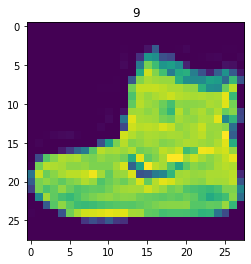

In [5]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

# prepare Data Loader

Right now, our data is in the form of pyTorch Datasets

DataLoader turns our dataset into a Python iterable

More specifically, we want to turn our data into batches(or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look(store in memory) at 60000 images in one hit. So we break it down to 32 images at a time(batch size of 32). 
2. It gives our neural network more chances to update its gradients per epoch.


In [6]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f99cf722c10>, <torch.utils.data.dataloader.DataLoader object at 0x7f99cf7224d0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [7]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

#Model Building

When starting tp build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequest models/experiments

In other words, start simply and ass complexity when necessary

In [8]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [10]:
output.shape

torch.Size([1, 784])

In [11]:
y= torch.tensor([[[1,2,3],[4,5,6]]])

In [12]:
y.shape

torch.Size([1, 2, 3])

In [13]:
flatten_model = nn.Flatten()
output = flatten_model(y)

In [14]:
output.shape

torch.Size([1, 6])

In [15]:
output

tensor([[1, 2, 3, 4, 5, 6]])

In [16]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(nn.Flatten(), nn.Linear(in_features = input_shape, out_features=hidden_units),
                                     nn.Linear(in_features = hidden_units, out_features = output_shape))
  def forward(self, x):
    return self.layer_stack

In [20]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=10 # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with 

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [25]:
dummy_x = torch.rand([1,1,28,28])
a=model_0(dummy_x)

In [28]:
a.forward(dummy_x)

tensor([[-0.1680,  0.2322,  0.2701,  0.0274,  0.6386,  0.3092,  0.3212,  0.2810,
         -0.1581, -0.1608]], grad_fn=<AddmmBackward0>)

In [36]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [37]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [35]:
Path("anscombe.json").is_file()

False